<a href="https://www.kaggle.com/code/tanish34/stock-market-prediction?scriptVersionId=227511435" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, Dropout, Dense, Input
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

2025-03-14 05:16:09.909893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 05:16:09.910012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 05:16:10.069489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/asian-paints1/Asian_Paints.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Sort by date (oldest first)
df = df.sort_values('Date').reset_index(drop=True)

In [3]:
# Clean numeric columns - remove commas and convert to float
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Convert Volume to numeric
df['Volume'] = df['Vol.'].str.replace('K', '*1e3').str.replace('M', '*1e6').map(pd.eval)

# Create technical indicators
def add_technical_indicators(df):
    # Moving Averages
    df['MA5'] = df['Price'].rolling(window=5).mean()
    df['MA20'] = df['Price'].rolling(window=20).mean()
    df['MA50'] = df['Price'].rolling(window=50).mean()
    
    # Exponential Moving Averages
    df['EMA12'] = df['Price'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Price'].ewm(span=26, adjust=False).mean()
    
    # MACD
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df['20MA'] = df['Price'].rolling(window=20).mean()
    df['20SD'] = df['Price'].rolling(window=20).std()
    df['upper_band'] = df['20MA'] + (df['20SD'] * 2)
    df['lower_band'] = df['20MA'] - (df['20SD'] * 2)
    
    # RSI
    delta = df['Price'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = -delta.clip(upper=0).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Price Rate of Change
    df['ROC'] = df['Price'].pct_change(periods=5) * 100
    
    # Average True Range
    df['TR'] = np.maximum(
        np.maximum(
            df['High'] - df['Low'],
            abs(df['High'] - df['Price'].shift(1))
        ),
        abs(df['Low'] - df['Price'].shift(1))
    )
    df['ATR'] = df['TR'].rolling(window=14).mean()
    
    # Volatility
    df['volatility'] = df['Price'].rolling(window=20).std()
    
    # Daily Returns
    df['daily_return'] = df['Price'].pct_change() * 100
    
    return df

# Add technical indicators
df = add_technical_indicators(df)

df = df.dropna()

In [4]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %,Volume,MA5,MA20,...,20MA,20SD,upper_band,lower_band,RSI,ROC,TR,ATR,volatility,daily_return
1238,2025-03-07,2270.0,2267.70,2277.95,2248.00,921.43K,0.10%,921430.0,2200.07,2228.8425,...,2228.8425,39.201830,2307.246160,2150.438840,56.119545,4.140383,29.95,41.157143,39.201830,0.101424
1239,2025-03-10,2278.6,2270.00,2293.00,2261.85,1.07M,0.38%,1070000.0,2222.51,2229.2225,...,2229.2225,39.666075,2308.554650,2149.890350,54.545455,5.179099,31.15,40.957143,39.666075,0.378855
1240,2025-03-11,2287.4,2274.00,2290.90,2257.90,601.23K,0.39%,601230.0,2253.57,2230.0850,...,2230.0850,40.774886,2311.634772,2148.535228,58.277926,7.283899,33.00,40.942857,40.774886,0.386202
1241,2025-03-12,2251.3,2287.40,2295.95,2247.00,749.23K,-1.58%,749230.0,2271.00,2230.6075,...,2230.6075,40.986497,2312.580495,2148.634505,51.818724,4.026985,48.95,42.746429,40.986497,-1.578211
1242,2025-03-13,2231.3,2255.25,2257.20,2222.50,747.50K,-0.89%,747500.0,2263.72,2230.7600,...,2230.7600,40.982938,2312.725876,2148.794124,47.430887,-1.605151,34.70,43.364286,40.982938,-0.888376


In [5]:
features = ['Price', 'Open', 'High', 'Low', 'Volume', 
            'MA5', 'MA20', 'EMA12', 'MACD', 'RSI', 'ROC', 
            'upper_band', 'lower_band', 'ATR', 'volatility']

# Prepare feature set
feature_df = df[features]

In [6]:
# Use StandardScaler for financial time series
scaler = StandardScaler()
scaled_data = scaler.fit_transform(feature_df)

# Create a separate price scaler for inverse transformation
price_scaler = StandardScaler()
price_scaler.fit_transform(df[['Price']])

array([[-2.58243261],
       [-2.54669441],
       [-2.53055099],
       ...,
       [-1.25945126],
       [-1.33983437],
       [-1.38436795]])

In [7]:
# Split data into training and testing sets (70/30)
training_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

In [8]:
# Function to create sequences
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        # Use all features for X
        a = dataset[i:(i + time_step)]
        X.append(a)
        # Use only the Price (index 0) for y
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Create sequences with 60 days time step
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [9]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (774, 60, 15)
Testing data shape: (298, 60, 15)


In [10]:
def build_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # CNN Block 1
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', 
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # CNN Block 2
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu',
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Bidirectional GRU
    x = Bidirectional(GRU(64, return_sequences=True, 
                          recurrent_dropout=0.1,
                          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(x)
    x = Dropout(0.3)(x)
    
    # Bidirectional LSTM
    x = Bidirectional(LSTM(32, return_sequences=True,
                          recurrent_dropout=0.1,
                          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(x)
    x = Dropout(0.3)(x)
    
    # Multi-head Attention
    attention_output = MultiHeadAttention(
        num_heads=4, key_dim=16
    )(x, x, x)
    x = LayerNormalization(epsilon=1e-6)(attention_output + x)
    
    # Final sequence processing
    x = LSTM(32, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    
    # Dense layers
    x = Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    outputs = Dense(1)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [11]:
# Create the model
model = build_model((X_train.shape[1], X_train.shape[2]))

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 64)    │      2,944 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 64)    │        128 │ conv1d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 30, 64)    │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 128)   │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 128)   │        256 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 15, 128)   │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 15, 128)   │     74,496 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 128)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 15, 64)    │     41,216 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 15, 64)    │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 64)    │     16,640 │ dropout_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_1[0][0],  │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        528 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         17 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,473 (677.63 KB)

 Trainable params: 173,473 (677.63 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile with Adam optimizer and Huber loss
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='huber',
    metrics=['mae', 'mse']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    mode='min',
    min_delta=0.0001,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

checkpoint_path = 'best_asian_paints_model.keras'
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [14]:
# Train the model
history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_test, y_test),
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)


Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.3137 - mae: 0.4638 - mse: 0.3537
Epoch 1: val_loss improved from inf to 0.24314, saving model to best_asian_paints_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - loss: 0.3112 - mae: 0.4599 - mse: 0.3484 - val_loss: 0.2431 - val_mae: 0.3755 - val_mse: 0.2041 - learning_rate: 0.0010
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1902 - mae: 0.2519 - mse: 0.0994
Epoch 2: val_loss improved from 0.24314 to 0.23031, saving model to best_asian_paints_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.1901 - mae: 0.2517 - mse: 0.0993 - val_loss: 0.2303 - val_mae: 0.3534 - val_mse: 0.1848 - learning_rate: 0.0010
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1753 - mae: 0.2130 - mse: 0.0764
Epoch 3: val_loss improved from 0.23031 to 0.19170, saving model to best_asian_paints_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.1752 - mae: 0.2128 - mse: 0.0763 - val_loss: 0

In [15]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [16]:
# Prepare for inverse scaling
train_pred_full = np.zeros((len(train_predict), len(features)))
test_pred_full = np.zeros((len(test_predict), len(features)))

# Set the first column (Price) to our predictions
train_pred_full[:, 0] = train_predict.flatten()
test_pred_full[:, 0] = test_predict.flatten()

# Inverse transform to get actual stock prices
train_predictions_actual = scaler.inverse_transform(train_pred_full)[:, 0]
test_predictions_actual = scaler.inverse_transform(test_pred_full)[:, 0]

# Get actual values
y_train_full = np.zeros((len(y_train), len(features)))
y_test_full = np.zeros((len(y_test), len(features)))
y_train_full[:, 0] = y_train
y_test_full[:, 0] = y_test
y_train_actual = scaler.inverse_transform(y_train_full)[:, 0]
y_test_actual = scaler.inverse_transform(y_test_full)[:, 0]

# Calculate performance metrics
train_mae = mean_absolute_error(y_train_actual, train_predictions_actual)
test_mae = mean_absolute_error(y_test_actual, test_predictions_actual)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions_actual))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions_actual))
train_r2 = r2_score(y_train_actual, train_predictions_actual)
test_r2 = r2_score(y_test_actual, test_predictions_actual)

print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing R²: {test_r2:.4f}")

Training MAE: 43.09
Testing MAE: 91.43
Training RMSE: 59.24
Testing RMSE: 121.61
Training R²: 0.9765
Testing R²: 0.8695


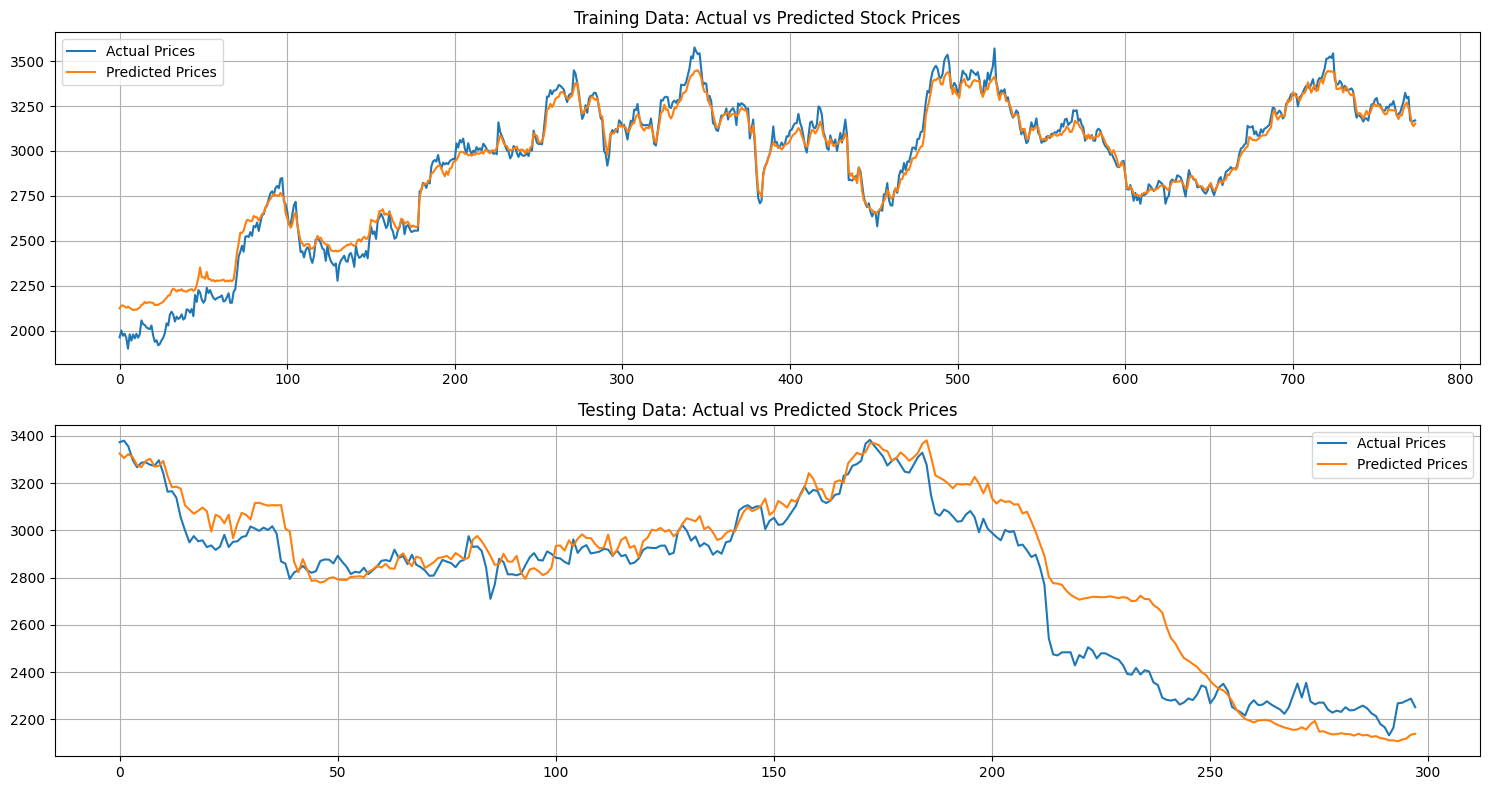

In [17]:
# Plot predictions vs actual
plt.figure(figsize=(15, 8))

# Training predictions
plt.subplot(2, 1, 1)
plt.plot(y_train_actual, label='Actual Prices')
plt.plot(train_predictions_actual, label='Predicted Prices')
plt.title('Training Data: Actual vs Predicted Stock Prices')
plt.legend()
plt.grid(True)

# Testing predictions
plt.subplot(2, 1, 2)
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(test_predictions_actual, label='Predicted Prices')
plt.title('Testing Data: Actual vs Predicted Stock Prices')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/tmp/ipykernel_24/3066057610.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_features[0] = next_pred  # Set price prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Future Pric

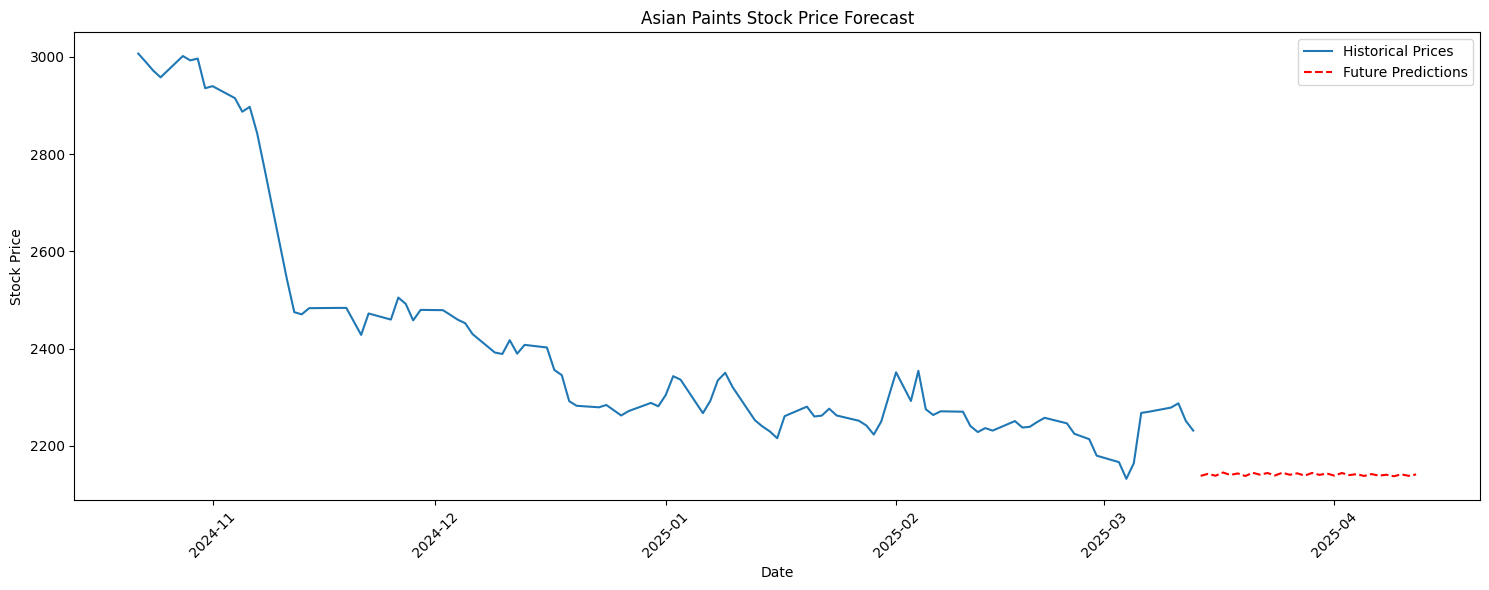

In [18]:
# Future predictions
def predict_future(model, last_sequence, n_steps=30):
    future_predictions = []
    current_sequence = last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1])
    
    for _ in range(n_steps):
        # Get prediction for next day
        next_pred = model.predict(current_sequence)[0]
        future_predictions.append(next_pred)
        
        # Update sequence for next prediction
        next_seq = current_sequence[0, 1:, :]
        next_features = np.zeros(current_sequence.shape[2])
        next_features[0] = next_pred  # Set price prediction
        
        # Use last values for other features (simple approach)
        next_features[1:] = next_seq[-1, 1:]
        
        # Add new timestep to sequence
        current_sequence = np.vstack([next_seq, next_features.reshape(1, -1)]).reshape(1, last_sequence.shape[0], last_sequence.shape[1])
    
    return np.array(future_predictions)

# Get last sequence from test data
last_sequence = X_test[-1]

# Predict next 30 days
future_preds = predict_future(model, last_sequence, 30)

# Prepare for inverse scaling
future_pred_full = np.zeros((len(future_preds), len(features)))
future_pred_full[:, 0] = future_preds.flatten()

# Inverse transform
future_prices = scaler.inverse_transform(future_pred_full)[:, 0]

# Get dates for future predictions
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Display future predictions
print("\nFuture Price Predictions for Asian Paints:")
for i, (date, price) in enumerate(zip(future_dates, future_prices)):
    print(f"Date: {date.strftime('%d-%m-%Y')}, Predicted Price: {price:.2f}")

# Plot future predictions
plt.figure(figsize=(15, 6))
# Plot historical data
historical_prices = df['Price'][-100:].values
historical_dates = df['Date'][-100:].values

# Plot
plt.plot(historical_dates, historical_prices, label='Historical Prices')
plt.plot(future_dates, future_prices, 'r--', label='Future Predictions')
plt.title('Asian Paints Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()